# Chicago Crime Data

## Import Necessary Libraries

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
import math
import types

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates

# Permanently changes the pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 7)

## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
from sklearn import set_config
set_config(display='diagram')

# set random seed
SEED = 42
np.random.seed(SEED)

# display more columns
pd.set_option('display.max_columns',50)
# display values with two decimal places and comma separation for powers of thousands.
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

import pandas._testing as tm

## Functions

In [2]:
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in thousands"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"

## Load the Data

In [3]:
# Import the data
path = 'Data/Chicago/Crimes_-_2001_to_Present.csv'
df_OE = pd.read_csv(path)
df_OE.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,631,6.00,8.00,44.00,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
1,11645836,JC212333,05/01/2016 12:25:00 AM,055XX S ROCKWELL ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,824,8.00,15.00,63.00,11,NaN,NaN,2016,04/06/2019 04:04:43 PM,NaN,NaN,NaN
2,11243268,JB167760,01/01/2017 12:01:00 AM,047XX N CLARK ST,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,APARTMENT,False,False,1913,19.00,47.00,3.00,17,NaN,NaN,2017,09/13/2018 03:56:52 PM,NaN,NaN,NaN
3,1896258,G749215,12/15/2001 02:00:00 AM,011XX N STATE ST,0460,BATTERY,SIMPLE,STREET,False,False,1824,18.00,NaN,NaN,08B,NaN,NaN,2001,08/17/2015 03:03:40 PM,NaN,NaN,NaN
4,11645527,JC212744,02/02/2015 10:00:00 AM,069XX W ARCHER AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER,False,False,811,8.00,23.00,56.00,11,NaN,NaN,2015,04/06/2019 04:04:43 PM,NaN,NaN,NaN


In [4]:
df = df_OE.copy()

## Prepare DataFrame

### Create datetime format index

In [5]:
# Examine single row
test_date = df.loc[0, 'Date']
test_date

'09/01/2018 12:01:00 AM'

In [6]:
# Check 'Date' for null values
df['Date'].isna().sum()

0

In [7]:
# Create a column in datetime format
df['CrimeDateTime'] = pd.to_datetime(df['Date'], format= '%m/%d/%Y %I:%M:%S %p', errors = 'coerce')

# Set datetime column as the index
df = df.set_index('CrimeDateTime')

# Order index according to ascending date order
df = df.sort_index(axis = 0)

df.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,11231026,JB152500,01/01/2001 12:00:00 AM,050XX N ASHLAND AVE,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,2032,20.00,47.00,3.00,02,NaN,NaN,2001,10/27/2018 04:00:07 PM,NaN,NaN,NaN
2001-01-01,9754975,HX403528,01/01/2001 12:00:00 AM,031XX W DOUGLAS BLVD,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,False,1022,10.00,24.00,29.00,17,NaN,NaN,2001,08/17/2015 03:03:40 PM,NaN,NaN,NaN
2001-01-01,9754865,HX403519,01/01/2001 12:00:00 AM,031XX W DOUGLAS BLVD,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,False,1022,10.00,24.00,29.00,17,NaN,NaN,2001,08/17/2015 03:03:40 PM,NaN,NaN,NaN


In [8]:
# Drop previous date column 
df = df.drop(columns = 'Date')
df.head(3)

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,
2001-01-01,11231026,JB152500,050XX N ASHLAND AVE,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,2032,20.00,47.00,3.00,02,NaN,NaN,2001,10/27/2018 04:00:07 PM,NaN,NaN,NaN
2001-01-01,9754975,HX403528,031XX W DOUGLAS BLVD,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,False,1022,10.00,24.00,29.00,17,NaN,NaN,2001,08/17/2015 03:03:40 PM,NaN,NaN,NaN
2001-01-01,9754865,HX403519,031XX W DOUGLAS BLVD,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,False,1022,10.00,24.00,29.00,17,NaN,NaN,2001,08/17/2015 03:03:40 PM,NaN,NaN,NaN


## Comparing Police Districts:
Which district has the most crimes? Which has the least?


In [9]:
pd.set_option('display.max_rows', 31)  # Display all rows returned

district_crime = df.groupby('District').size()
display(district_crime)
#display(district_crime.sort_values(ascending = False))

pd.reset_option('display.max_rows')    # Display reset to default number

District
1.00     318911
2.00     372694
3.00     398782
4.00     446471
5.00     348163
6.00     459892
7.00     453766
8.00     528106
9.00     383920
10.00    338841
11.00    504195
12.00    390253
14.00    304040
15.00    336305
16.00    263410
17.00    226906
18.00    353146
19.00    353566
20.00    139264
21.00         4
22.00    257611
24.00    237806
25.00    447029
31.00       247
dtype: int64

In [10]:
min_idx, max_idx = district_crime.agg(['idxmin','idxmax'])
min_idx = int(min_idx)
max_idx = int(max_idx)
min_idx, max_idx

(21, 8)

In [11]:
max_val = district_crime.loc[max_idx]
min_val = district_crime.loc[min_idx]
display(max_val, min_val)

528106

4

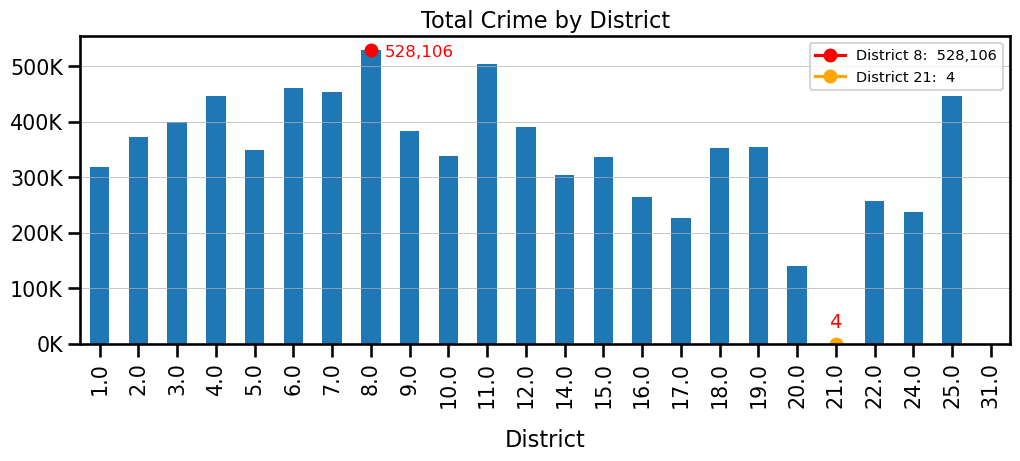

In [12]:
# Plot Total Crime by District
fig, ax = plt.subplots(figsize=(12,4))
district_crime.plot(ax=ax, title = 'Total Crime by District', kind='bar')

# Plot maximum crime point
ax.plot([max_idx-1],[max_val], marker='o', color = 'red')
ax.text(max_idx-1+.35, max_val-11000, f'{max_val:,}', fontsize=12, color='red')

## Plot minimum crime point
ax.plot([min_idx-2],[min_val], marker='o', color = 'orange')
ax.text(min_idx-2-.15, min_val+30000, f'{min_val:,}', fontsize=14, color='red')

# Manually space x-axis label
plt.xlabel('District',labelpad=15)

# Create the formatters
fmt_thous = mticks.FuncFormatter(thousands)

# Format axis labels
fmt_thous = mticks.FuncFormatter(thousands)
ax.yaxis.set_major_formatter(fmt_thous)

# Grid and Legend
ax.grid(which='major', axis='y', lw=0.5)
ax.legend([f'District {max_idx}:  {(max_val):,}', f'District {min_idx}:  {(min_val):,}'], prop={'size':10.5});

* We can see that the district with the most crimes is District #8 with 528,106 crimes.
* We can see that the district with the least crimes is District #21 with 4 crimes.

## Crimes Across the Years:
Is the total number of crimes increasing or decreasing across the years?

Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?


### Overall Crime Trend

In [13]:
# Create sample dataframe to test code on
#df_long_sample = df_long.sample(n = 1000, random_state = 42)

In [14]:
# Specify shape of dataframe (long)
df_long = df
df_long.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7863375 entries, 2001-01-01 00:00:00 to 2023-08-04 23:57:00
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Block                 object 
 3   IUCR                  object 
 4   Primary Type          object 
 5   Description           object 
 6   Location Description  object 
 7   Arrest                bool   
 8   Domestic              bool   
 9   Beat                  int64  
 10  District              float64
 11  Ward                  float64
 12  Community Area        float64
 13  FBI Code              object 
 14  X Coordinate          float64
 15  Y Coordinate          float64
 16  Year                  int64  
 17  Updated On            object 
 18  Latitude              float64
 19  Longitude             float64
 20  Location              object 
dtypes: bool(2), float64(7), int64(3), object(9)


In [15]:
df_long.head(3)

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,
2001-01-01,11231026,JB152500,050XX N ASHLAND AVE,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,2032,20.00,47.00,3.00,02,NaN,NaN,2001,10/27/2018 04:00:07 PM,NaN,NaN,NaN
2001-01-01,9754975,HX403528,031XX W DOUGLAS BLVD,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,False,1022,10.00,24.00,29.00,17,NaN,NaN,2001,08/17/2015 03:03:40 PM,NaN,NaN,NaN
2001-01-01,9754865,HX403519,031XX W DOUGLAS BLVD,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,False,1022,10.00,24.00,29.00,17,NaN,NaN,2001,08/17/2015 03:03:40 PM,NaN,NaN,NaN


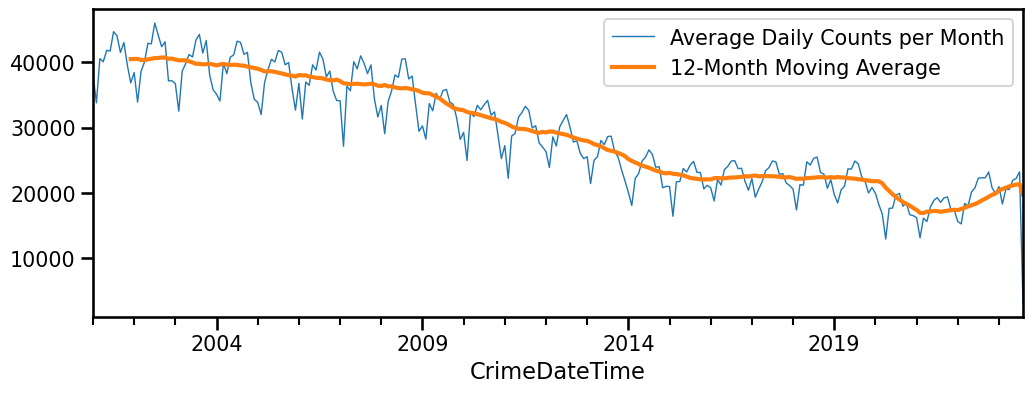

In [16]:
# Resample data to find Average Daily Crime Count per Month
df_ts = df_long.resample('MS').size()

# Rolling average over a number of months
window = 12
df_ts_mean = df_ts.rolling(window).mean()

# Plot Average Daily Counts per Month & Moving Average
ax = df_ts.plot(label='Average Daily Counts per Month', lw=1, figsize=(12,4))
df_ts_mean.plot(label=f'{window}-Month Moving Average', ax=ax, lw=3)
ax.legend();

We can see that the total number of crimes has been decreasing from 2003 to 2021. After 2021, there seems to be a slight rebound in crime, back to 2015-2019 levels, after a dip for about two years during 2020-2021.

### Individual Crime Trends: Code Testing

In [17]:
# Get number of crimes per year
df.groupby('Primary Type').size().head()

Primary Type
ARSON                                  13415
ASSAULT                               514169
BATTERY                              1436548
BURGLARY                              426548
CONCEALED CARRY LICENSE VIOLATION       1137
dtype: int64

In [18]:
# Create blank dictionary
CRIMES = {}

# Test single crime category
crime = 'BATTERY'
crime

'BATTERY'

In [19]:
temp = df.loc[ df["Primary Type"] == crime]
temp.head(3)

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,1310541,G000008,078XX S ESSEX AV,0460,BATTERY,SIMPLE,RESIDENCE,False,False,421,4.00,NaN,NaN,08B,"1,194,175.00","1,853,638.00",2001,08/17/2015 03:03:40 PM,41.75,-87.56,"(41.753316255, -87.563985474)"
2001-01-01 00:01:00,1376172,G086109,023XX S STATE ST,0460,BATTERY,SIMPLE,CHA HALLWAY/STAIRWELL/ELEVATOR,False,True,2113,2.00,NaN,NaN,08B,"1,176,644.00","1,888,766.00",2001,08/17/2015 03:03:40 PM,41.85,-87.63,"(41.850123042, -87.627171802)"
2001-01-01 00:05:00,1311915,G000393,020XX W 69 ST,0460,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,735,7.00,NaN,NaN,08B,"1,163,874.00","1,858,853.00",2001,08/17/2015 03:03:40 PM,41.77,-87.67,"(41.768316843, -87.674880757)"


In [20]:
# Resample temporary dataframe as yearly data (crime counts). Keep only size
temp_res = temp.resample("A").size()
display(temp_res.head(), temp_res.tail())
#temp_res

CrimeDateTime
2001-12-31    93461
2002-12-31    94153
2003-12-31    88380
2004-12-31    87136
2005-12-31    83964
Freq: A-DEC, dtype: int64

CrimeDateTime
2019-12-31    49517
2020-12-31    41512
2021-12-31    40460
2022-12-31    40899
2023-12-31    25680
Freq: A-DEC, dtype: int64

In [21]:
CRIMES[crime] = temp_res.copy()
CRIMES.keys()

dict_keys(['BATTERY'])

In [22]:
# temporarily sampled yearly in order to get list of crimes types
CRIMES['BATTERY']

CrimeDateTime
2001-12-31    93461
2002-12-31    94153
2003-12-31    88380
2004-12-31    87136
2005-12-31    83964
2006-12-31    80666
2007-12-31    79593
2008-12-31    75926
2009-12-31    68460
2010-12-31    65401
2011-12-31    60459
2012-12-31    59134
2013-12-31    54006
2014-12-31    49452
2015-12-31    48923
2016-12-31    50299
2017-12-31    49239
2018-12-31    49828
2019-12-31    49517
2020-12-31    41512
2021-12-31    40460
2022-12-31    40899
2023-12-31    25680
Freq: A-DEC, dtype: int64

### Individual Crime Trends: Full Data

In [23]:
# 1. get list of unique crime descriptions
crime_list = df["Primary Type"].unique()
crime_list

array(['OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE', 'THEFT',
       'DECEPTIVE PRACTICE', 'CRIM SEXUAL ASSAULT', 'CRIMINAL DAMAGE',
       'OTHER OFFENSE', 'ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'BURGLARY',
       'BATTERY', 'MOTOR VEHICLE THEFT', 'WEAPONS VIOLATION',
       'CRIMINAL TRESPASS', 'ROBBERY', 'NARCOTICS',
       'LIQUOR LAW VIOLATION', 'PUBLIC PEACE VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'STALKING', 'HOMICIDE',
       'GAMBLING', 'KIDNAPPING', 'PROSTITUTION', 'INTIMIDATION', 'ARSON',
       'RITUALISM', 'DOMESTIC VIOLENCE', 'OBSCENITY',
       'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL',
       'HUMAN TRAFFICKING', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'NON - CRIMINAL'], dtype=object)

In [24]:
# 2. Create a new empty dictionary  
CRIMES = {}

In [25]:
# 3. Loop through the list of crimes
for crime in crime_list:
    
    # I. Save a temp df of just the rows that match the crime
   temp = df.loc[ df["Primary Type"]==crime].copy()

    # II. RESAMPLE the temp DataFrame as Monthly data (crime counts) 
    # and keep ONLY the .size() 
   temp_res = temp.resample("MS").size() 

   # III. Save the temporary DataFrame in the dictionary,
   # using the crime description as the key.
   CRIMES[crime] = temp_res.copy() 
    
# CRIMES is now resampled as monthly
CRIMES.keys()

dict_keys(['OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE', 'THEFT', 'DECEPTIVE PRACTICE', 'CRIM SEXUAL ASSAULT', 'CRIMINAL DAMAGE', 'OTHER OFFENSE', 'ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'BURGLARY', 'BATTERY', 'MOTOR VEHICLE THEFT', 'WEAPONS VIOLATION', 'CRIMINAL TRESPASS', 'ROBBERY', 'NARCOTICS', 'LIQUOR LAW VIOLATION', 'PUBLIC PEACE VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER', 'STALKING', 'HOMICIDE', 'GAMBLING', 'KIDNAPPING', 'PROSTITUTION', 'INTIMIDATION', 'ARSON', 'RITUALISM', 'DOMESTIC VIOLENCE', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY', 'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL', 'HUMAN TRAFFICKING', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON - CRIMINAL'])

In [26]:
# Test a single type
CRIMES['BATTERY']

CrimeDateTime
2001-01-01    6527
2001-02-01    6042
2001-03-01    7662
2001-04-01    8328
2001-05-01    8887
              ... 
2023-04-01    3601
2023-05-01    3953
2023-06-01    3858
2023-07-01    4170
2023-08-01     477
Freq: MS, Length: 272, dtype: int64

In [27]:
crimes_df = pd.DataFrame(CRIMES)
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,OTHER NARCOTIC VIOLATION,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING,NON-CRIMINAL (SUBJECT SPECIFIED),NON - CRIMINAL
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,162.00,3966,2800,2123,3,1934,6527,2097,337,1192,1396,4714,101,161,36,26,42,44.00,75,563.00,18,67,2.00,1.00,2.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
2001-02-01,152,149,6669,1163,134.00,3665,2488,2029,1,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37.00,57,426.00,24,57,0.00,NaN,1.00,0.00,1.00,NaN,NaN,NaN,NaN,NaN
2001-03-01,195,184,7766,1313,149.00,4617,2836,2824,4,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55.00,72,550.00,22,93,2.00,NaN,2.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN


In [28]:
# Remove all NaN values and drop all float/decimal values and covert into type integer.
crimes_df = crimes_df.fillna(0).astype(int)
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,OTHER NARCOTIC VIOLATION,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING,NON-CRIMINAL (SUBJECT SPECIFIED),NON - CRIMINAL
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,162,3966,2800,2123,3,1934,6527,2097,337,1192,1396,4714,101,161,36,26,42,44,75,563,18,67,2,1,2,1,0,0,0,0,0,0
2001-02-01,152,149,6669,1163,134,3665,2488,2029,1,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37,57,426,24,57,0,0,1,0,1,0,0,0,0,0
2001-03-01,195,184,7766,1313,149,4617,2836,2824,4,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55,72,550,22,93,2,0,2,0,0,0,0,0,0,0


### Combine Duplicate Crime Names

In [29]:
# Display all crime types
df["Primary Type"].unique()

array(['OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE', 'THEFT',
       'DECEPTIVE PRACTICE', 'CRIM SEXUAL ASSAULT', 'CRIMINAL DAMAGE',
       'OTHER OFFENSE', 'ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'BURGLARY',
       'BATTERY', 'MOTOR VEHICLE THEFT', 'WEAPONS VIOLATION',
       'CRIMINAL TRESPASS', 'ROBBERY', 'NARCOTICS',
       'LIQUOR LAW VIOLATION', 'PUBLIC PEACE VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'STALKING', 'HOMICIDE',
       'GAMBLING', 'KIDNAPPING', 'PROSTITUTION', 'INTIMIDATION', 'ARSON',
       'RITUALISM', 'DOMESTIC VIOLENCE', 'OBSCENITY',
       'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL',
       'HUMAN TRAFFICKING', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'NON - CRIMINAL'], dtype=object)

We can see that a few of our crimes will need to be combined, as they are actually the same type of crime. They are:

> * CRIM SEXUAL ASSULAT
> * CRIMINAL SEXUAL ASSAULT

> * NARCOTICS
> * OTHER NARCOTIC VIOLATION

> * NON-CRIMINAL
> * NON - CRIMINAL
> * NON-CRIMINAL (SUBJECT SPECIFIED)

We will combine each of those sets into a single crime for more accurate analysis.

In [30]:
# Sample code for combining values of separate columns into a single, summed column.
a = {"x" : range(1,5), "y" : range(6,10)}

test_df = pd.DataFrame(a)

test_df['x_plus_y'] = (test_df['x'] + test_df['y'])
test_df

,x,y,x_plus_y
0,1,6,7
1,2,7,9
2,3,8,11
3,4,9,13


In [31]:
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,OTHER NARCOTIC VIOLATION,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING,NON-CRIMINAL (SUBJECT SPECIFIED),NON - CRIMINAL
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,162,3966,2800,2123,3,1934,6527,2097,337,1192,1396,4714,101,161,36,26,42,44,75,563,18,67,2,1,2,1,0,0,0,0,0,0
2001-02-01,152,149,6669,1163,134,3665,2488,2029,1,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37,57,426,24,57,0,0,1,0,1,0,0,0,0,0
2001-03-01,195,184,7766,1313,149,4617,2836,2824,4,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55,72,550,22,93,2,0,2,0,0,0,0,0,0,0


In [32]:
# Verify method to grab desired column
print(crimes_df['CRIMINAL SEXUAL ASSAULT'].head(3))
print()
print(crimes_df['CRIM SEXUAL ASSAULT'].head(3))

CrimeDateTime
2001-01-01    3
2001-02-01    1
2001-03-01    4
Freq: MS, Name: CRIMINAL SEXUAL ASSAULT, dtype: int64

CrimeDateTime
2001-01-01    162
2001-02-01    134
2001-03-01    149
Freq: MS, Name: CRIM SEXUAL ASSAULT, dtype: int64


In [33]:
# Verify that column values are correctly added together: yes
(crimes_df['CRIMINAL SEXUAL ASSAULT'] + crimes_df['CRIM SEXUAL ASSAULT']).head(3)

CrimeDateTime
2001-01-01    165
2001-02-01    135
2001-03-01    153
Freq: MS, dtype: int64

In [34]:
# Combine redundant/miscatorgorized/duplicate columns/crimes
col_1 = 'CRIMINAL SEXUAL ASSAULT'
col_2 = 'CRIM SEXUAL ASSAULT'

crimes_df[col_1] = (crimes_df[col_1] + crimes_df[col_2])
crimes_df[col_1].head(3)

CrimeDateTime
2001-01-01    165
2001-02-01    135
2001-03-01    153
Freq: MS, Name: CRIMINAL SEXUAL ASSAULT, dtype: int64

In [35]:
# Combine redundant/miscatorgorized/duplicate columns/crimes
col_1 = 'NARCOTICS'
col_2 = 'OTHER NARCOTIC VIOLATION'

crimes_df[col_1] = (crimes_df[col_1] + crimes_df[col_2])
crimes_df[col_1].head(3)

CrimeDateTime
2001-01-01    4715
2001-02-01    4369
2001-03-01    4862
Freq: MS, Name: NARCOTICS, dtype: int64

In [36]:
# Combine redundant/miscatorgorized/duplicate columns/crimes
col_1 = 'NON-CRIMINAL'
col_2 = 'NON - CRIMINAL'
col_3 = 'NON-CRIMINAL (SUBJECT SPECIFIED)'
col_date = '2016-01-01'

print(f"{col_1} value on {col_date} is: {crimes_df.loc[col_date][col_1]}")
print(f"{col_2} value on {col_date} is: {crimes_df.loc[col_date][col_2]}")
print(f"{col_3} value on {col_date} is: {crimes_df.loc[col_date][col_3]}")
print()

crimes_df[col_1] = (crimes_df[col_1] + crimes_df[col_2] + crimes_df[col_3])
print(f"{col_1}'s NEW value on {col_date} is: {crimes_df.loc[col_date][col_1]}")

NON-CRIMINAL value on 2016-01-01 is: 2
NON - CRIMINAL value on 2016-01-01 is: 1
NON-CRIMINAL (SUBJECT SPECIFIED) value on 2016-01-01 is: 1

NON-CRIMINAL's NEW value on 2016-01-01 is: 4


In [37]:
# Drop all redundant columns from the dataframe
drop_list = ['NON - CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)','OTHER NARCOTIC VIOLATION','CRIM SEXUAL ASSAULT']

crimes_df.drop(drop_list, axis=1, inplace=True)
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,3966,2800,2123,165,1934,6527,2097,337,1192,1396,4715,101,161,36,26,42,44,75,563,18,67,2,1,2,0,0,0,0
2001-02-01,152,149,6669,1163,3665,2488,2029,135,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37,57,426,24,57,0,0,1,1,0,0,0
2001-03-01,195,184,7766,1313,4617,2836,2824,153,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55,72,550,22,93,2,0,2,0,0,0,0


Now all redundant/duplicate crimes have been combined into a single column for each crime; old columns have been removed.

### Individual Crime Trends: Via Seasonal Decomposition

#### Coding Testing using sample of dictionary

In [38]:
CRIMES_short = { k: v for (k,v) in CRIMES.items() if len(k) < 8}
CRIMES_short.keys()

keys_short = list(CRIMES_short.keys())
display(keys_short)
print(type(keys_short))

['THEFT', 'ASSAULT', 'BATTERY', 'ROBBERY', 'ARSON']

<class 'list'>


In [39]:
# Create sampled df during development
crimes_df_sample = pd.DataFrame(crimes_df, columns=(keys_short))
crimes_df_sample.reset_index(level = ['CrimeDateTime'], inplace = True)
crimes_df_sample

,CrimeDateTime,THEFT,ASSAULT,BATTERY,ROBBERY,ARSON
0,2001-01-01,7867,2123,6527,1396,67
1,2001-02-01,6669,2029,6042,1159,57
2,2001-03-01,7766,2824,7662,1399,93
3,2001-04-01,7702,2746,8328,1341,89
4,2001-05-01,8420,2903,8887,1491,94
...,...,...,...,...,...,...
267,2023-04-01,4335,1808,3601,752,36
268,2023-05-01,4691,2012,3953,770,54
269,2023-06-01,4982,2017,3858,786,48
270,2023-07-01,4975,2025,4170,1010,41


In [40]:
# Index should be of type DatetimeIndex 
crimes_df_sample.index

RangeIndex(start=0, stop=272, step=1)

In [41]:
# Create a column in datetime format
crimes_df_sample['CrimeDateTime'] = pd.to_datetime(crimes_df_sample['CrimeDateTime'], format= '%Y/%m/%d', errors = 'coerce')

# Set datetime column as the index
crimes_df_sample = crimes_df_sample.set_index('CrimeDateTime')

# Order index according to ascending date order
crimes_df_sample = crimes_df_sample.sort_index(axis = 0)

crimes_df_sample.head(3)

,THEFT,ASSAULT,BATTERY,ROBBERY,ARSON
CrimeDateTime,,,,,
2001-01-01,7867,2123,6527,1396,67
2001-02-01,6669,2029,6042,1159,57
2001-03-01,7766,2824,7662,1399,93


In [42]:
crimes_df_sample.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01'],
              dtype='datetime64[ns]', name='CrimeDateTime', length=272, freq=None)

In [43]:
crimes_df_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 272 entries, 2001-01-01 to 2023-08-01
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   THEFT    272 non-null    int64
 1   ASSAULT  272 non-null    int64
 2   BATTERY  272 non-null    int64
 3   ROBBERY  272 non-null    int64
 4   ARSON    272 non-null    int64
dtypes: int64(5)
memory usage: 12.8 KB


In [44]:
# Test code to grab column values by column index
crimes_df_sample.iloc[:,0]

CrimeDateTime
2001-01-01    7867
2001-02-01    6669
2001-03-01    7766
2001-04-01    7702
2001-05-01    8420
              ... 
2023-04-01    4335
2023-05-01    4691
2023-06-01    4982
2023-07-01    4975
2023-08-01     738
Name: THEFT, Length: 272, dtype: int64

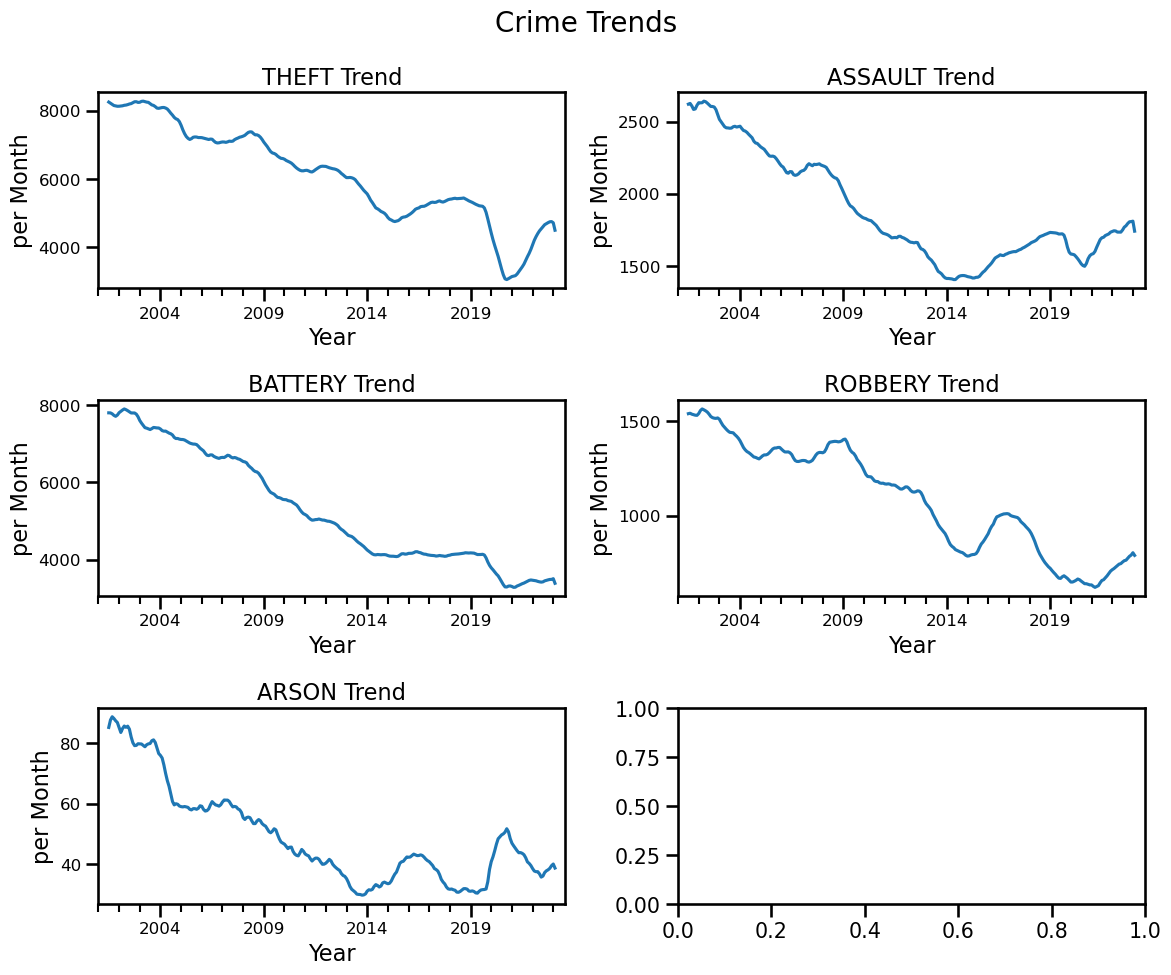

In [45]:
## Plot Monthly Crime Trends for all crimes
# Source: https://stackoverflow.com/questions/64229894/how-to-fix-numpy-ndarray-object-has-no-attribute-get-figure-when-plotting-su

# Instantiate values to size figure
plot_length = len(crimes_df_sample.columns)
max_row = math.ceil(plot_length/2)
max_col = 2

# Set figure dimension and layout of subplots
fig, axes = plt.subplots(max_row, max_col, figsize=(12, plot_length*2))

# Flatten array of axes to have a single group of multiple subplots vs multiple groups
axe = axes.ravel()

# Iterate over columns 
for i, c in enumerate(crimes_df_sample.columns):
    #crimes_df_sample[c].plot(ax=axe[i], title=c, ylabel="Monthly Count") # part of original example
    
    # create seasonal decomposition for each column
    decomp = tsa.seasonal_decompose(crimes_df_sample.iloc[:,i])
    
    # extract "Trend" to plot for each crime type
    decomp.trend.plot(title=f'{c} Trend', ax=axe[i], xlabel="Year", ylabel="per Month", fontsize=12)
    

fig.suptitle('Crime Trends', fontsize=20)

fig.tight_layout()

The sample code has been figured out and will now be applied to the full data.

#### Implement using full data

In [46]:
keys = list(crimes_df.columns)
print(type(keys), f'\n crime type count: {len(keys)}')
display(keys)

<class 'list'> 
 crime type count: 32


['OFFENSE INVOLVING CHILDREN',
 'SEX OFFENSE',
 'THEFT',
 'DECEPTIVE PRACTICE',
 'CRIMINAL DAMAGE',
 'OTHER OFFENSE',
 'ASSAULT',
 'CRIMINAL SEXUAL ASSAULT',
 'BURGLARY',
 'BATTERY',
 'MOTOR VEHICLE THEFT',
 'WEAPONS VIOLATION',
 'CRIMINAL TRESPASS',
 'ROBBERY',
 'NARCOTICS',
 'LIQUOR LAW VIOLATION',
 'PUBLIC PEACE VIOLATION',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'STALKING',
 'HOMICIDE',
 'GAMBLING',
 'KIDNAPPING',
 'PROSTITUTION',
 'INTIMIDATION',
 'ARSON',
 'RITUALISM',
 'DOMESTIC VIOLENCE',
 'OBSCENITY',
 'PUBLIC INDECENCY',
 'CONCEALED CARRY LICENSE VIOLATION',
 'NON-CRIMINAL',
 'HUMAN TRAFFICKING']

In [47]:
# Index should be of type DatetimeIndex 
crimes_df.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01'],
              dtype='datetime64[ns]', name='CrimeDateTime', length=272, freq='MS')

In [48]:
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,3966,2800,2123,165,1934,6527,2097,337,1192,1396,4715,101,161,36,26,42,44,75,563,18,67,2,1,2,0,0,0,0
2001-02-01,152,149,6669,1163,3665,2488,2029,135,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37,57,426,24,57,0,0,1,1,0,0,0
2001-03-01,195,184,7766,1313,4617,2836,2824,153,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55,72,550,22,93,2,0,2,0,0,0,0


In [49]:
crimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 272 entries, 2001-01-01 to 2023-08-01
Freq: MS
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   OFFENSE INVOLVING CHILDREN         272 non-null    int64
 1   SEX OFFENSE                        272 non-null    int64
 2   THEFT                              272 non-null    int64
 3   DECEPTIVE PRACTICE                 272 non-null    int64
 4   CRIMINAL DAMAGE                    272 non-null    int64
 5   OTHER OFFENSE                      272 non-null    int64
 6   ASSAULT                            272 non-null    int64
 7   CRIMINAL SEXUAL ASSAULT            272 non-null    int64
 8   BURGLARY                           272 non-null    int64
 9   BATTERY                            272 non-null    int64
 10  MOTOR VEHICLE THEFT                272 non-null    int64
 11  WEAPONS VIOLATION                  272 non-null    int64

In [50]:
# Test code to grab column values by column index
crimes_df.iloc[:,0]

CrimeDateTime
2001-01-01    246
2001-02-01    152
2001-03-01    195
2001-04-01    196
2001-05-01    213
             ... 
2023-04-01    162
2023-05-01    170
2023-06-01    124
2023-07-01    132
2023-08-01     15
Freq: MS, Name: OFFENSE INVOLVING CHILDREN, Length: 272, dtype: int64

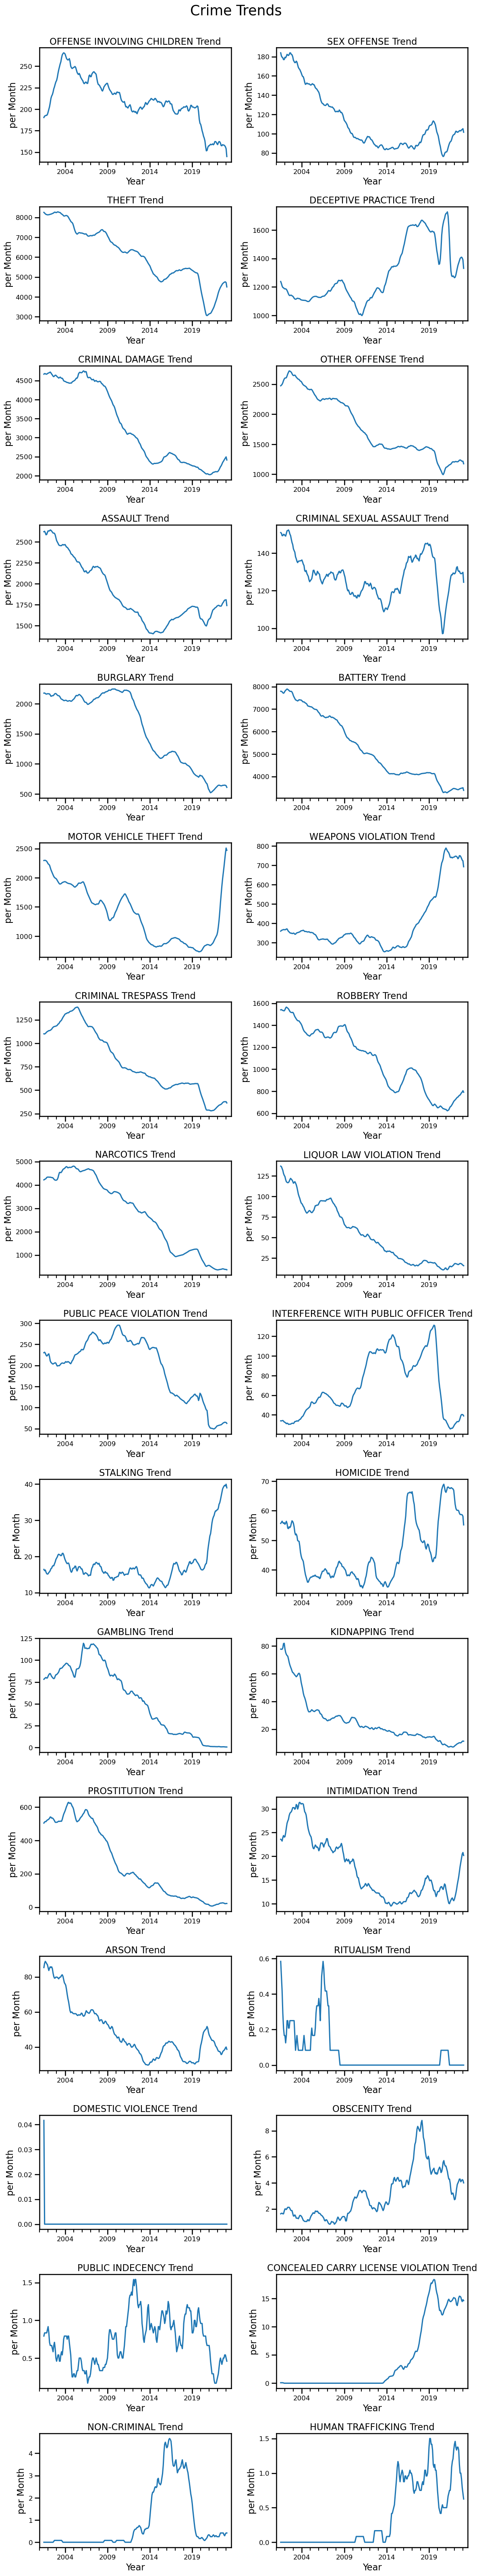

In [51]:
## Plot Monthly Crime Trends for all crimes
# Source: https://stackoverflow.com/questions/64229894/how-to-fix-numpy-ndarray-object-has-no-attribute-get-figure-when-plotting-su

# Instantiate values to size figure
plot_length = len(crimes_df.columns)
max_row = math.ceil(plot_length/2)
max_col = 2

# Set figure dimension and layout of subplots
fig, axes = plt.subplots(max_row, max_col, figsize=(12, plot_length*2))

# Flatten array of axes to have a single group of multiple subplots vs multiple groups
axe = axes.ravel()

# Iterate over columns 
for i, c in enumerate(crimes_df.columns):
    #crimes_df_sample[c].plot(ax=axe[i], title=c, ylabel="Monthly Count") # part of original example
    
    # create seasonal decomposition for each column
    decomp = tsa.seasonal_decompose(crimes_df.iloc[:,i])
    
    # extract "Trend" to plot for each crime type
    decomp.trend.plot(title=f'{c} Trend', ax=axe[i], xlabel="Year", ylabel="per Month", fontsize=12)
    

fig.suptitle('Crime Trends', fontsize=25, y=1)

fig.tight_layout()

We saw in the "Overall Crime Trend" Section, that according to the dataset, the total number of crimes was decreasing from 2003 to 2021, with a slight dip and recovery during COVID from 2021 to 2023. 

Looking at the individual crime trends above, at least one of the trends seems anomalous (Domestic Violence), while most of the rest follow the same general trend of decreasing crime rates.

There are some exceptions. The most clear exceptions go from stable levels to very high levels by 2023. These include the following:

> * Weapons Violation
> * Stalking
> * Concealed Carry License Violation
> * Human Trafficking

Some others had a large peak in the middle of our time frame, but dropped from that peak to a level that is still higher than in 2001. These include:

> * Deceptive Practice
> * Obscenity

Similarly, some had peaks and/or valleys in the middle of our time time frame, but returned to levels similar to what they were in 2001. These include:

> * Motor Vehicle Theft
> * Interference with Public Officer
> * Homicide
> * Intimidation
> * Public Indecency
> * Non-Criminal


## Comparing Months:
What months have the most crime? What months have the least?

Are there any individual crimes that do not follow this pattern? If so, which crimes?


### Total Crime Average by Month

In [52]:
total_crime_count = len(crimes_df.columns)

In [53]:
total_crime_count

32

In [54]:
# Create 'Total Crime' column for binning
crimes_df['Total Crime'] = crimes_df.iloc[:, range(len(crimes_df.columns))].sum(axis =1)
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING,Total Crime
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,3966,2800,2123,165,1934,6527,2097,337,1192,1396,4715,101,161,36,26,42,44,75,563,18,67,2,1,2,0,0,0,0,38119
2001-02-01,152,149,6669,1163,3665,2488,2029,135,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37,57,426,24,57,0,0,1,1,0,0,0,33787
2001-03-01,195,184,7766,1313,4617,2836,2824,153,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55,72,550,22,93,2,0,2,0,0,0,0,40566


In [55]:
# Extract month
crimes_df['Month'] = crimes_df.index.month
crimes_df['MonthName'] = crimes_df.index.month_name()
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING,Total Crime,Month,MonthName
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,3966,2800,2123,165,1934,6527,2097,337,1192,1396,4715,101,161,36,26,42,44,75,563,18,67,2,1,2,0,0,0,0,38119,1,January
2001-02-01,152,149,6669,1163,3665,2488,2029,135,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37,57,426,24,57,0,0,1,1,0,0,0,33787,2,February
2001-03-01,195,184,7766,1313,4617,2836,2824,153,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55,72,550,22,93,2,0,2,0,0,0,0,40566,3,March


In [56]:
# Save lookup for number vs name
unique_months = crimes_df.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup = dict(zip(unique_months['Month'], unique_months['MonthName']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

### Total Crime Average by Month: Graph

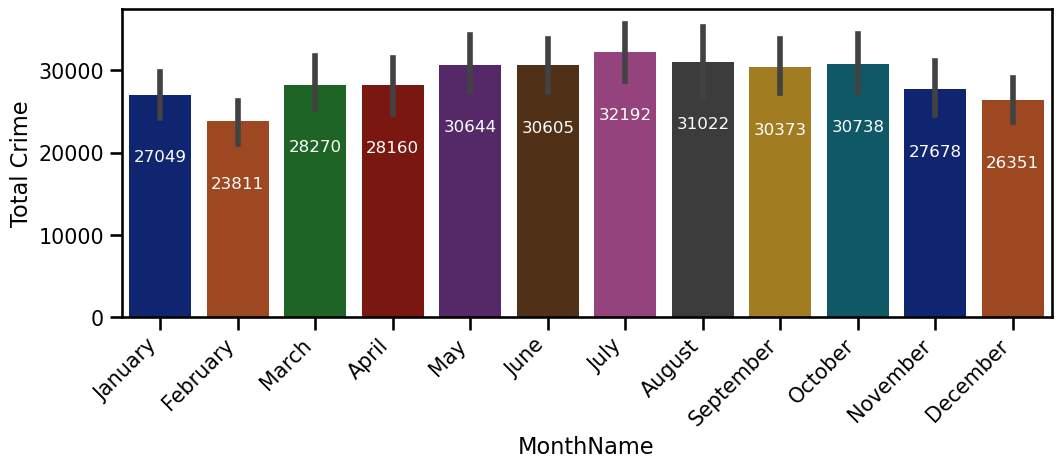

In [57]:
ax = sns.barplot(data=crimes_df, y='Total Crime', x='MonthName', palette='dark', 
                 order=month_lookup.values());

# Source: https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
ax.bar_label(ax.containers[0], fmt='%.0f', fontsize=12, padding=-50, color='white')  

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha= 'right');

fig.tight_layout()

We can see the average total crime per month.

Highest Total Average: 
> * July
> * 32,192

Lowest Total Average:
> * February
> * 23,811

### Individual Crime Averages by Month

Are there any individual crimes that do not follow this pattern? If so, which crimes?

In [58]:
# 1. get list of unique crime descriptions
crime_list = list(crimes_df.columns)
crime_list

['OFFENSE INVOLVING CHILDREN',
 'SEX OFFENSE',
 'THEFT',
 'DECEPTIVE PRACTICE',
 'CRIMINAL DAMAGE',
 'OTHER OFFENSE',
 'ASSAULT',
 'CRIMINAL SEXUAL ASSAULT',
 'BURGLARY',
 'BATTERY',
 'MOTOR VEHICLE THEFT',
 'WEAPONS VIOLATION',
 'CRIMINAL TRESPASS',
 'ROBBERY',
 'NARCOTICS',
 'LIQUOR LAW VIOLATION',
 'PUBLIC PEACE VIOLATION',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'STALKING',
 'HOMICIDE',
 'GAMBLING',
 'KIDNAPPING',
 'PROSTITUTION',
 'INTIMIDATION',
 'ARSON',
 'RITUALISM',
 'DOMESTIC VIOLENCE',
 'OBSCENITY',
 'PUBLIC INDECENCY',
 'CONCEALED CARRY LICENSE VIOLATION',
 'NON-CRIMINAL',
 'HUMAN TRAFFICKING',
 'Total Crime',
 'Month',
 'MonthName']

In [59]:
# Drop irrelevant columns (last three)
crime_list = crime_list[:-3]
crime_list

['OFFENSE INVOLVING CHILDREN',
 'SEX OFFENSE',
 'THEFT',
 'DECEPTIVE PRACTICE',
 'CRIMINAL DAMAGE',
 'OTHER OFFENSE',
 'ASSAULT',
 'CRIMINAL SEXUAL ASSAULT',
 'BURGLARY',
 'BATTERY',
 'MOTOR VEHICLE THEFT',
 'WEAPONS VIOLATION',
 'CRIMINAL TRESPASS',
 'ROBBERY',
 'NARCOTICS',
 'LIQUOR LAW VIOLATION',
 'PUBLIC PEACE VIOLATION',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'STALKING',
 'HOMICIDE',
 'GAMBLING',
 'KIDNAPPING',
 'PROSTITUTION',
 'INTIMIDATION',
 'ARSON',
 'RITUALISM',
 'DOMESTIC VIOLENCE',
 'OBSCENITY',
 'PUBLIC INDECENCY',
 'CONCEALED CARRY LICENSE VIOLATION',
 'NON-CRIMINAL',
 'HUMAN TRAFFICKING']

In [60]:
# 2. Create a new empty dictionary  
CRIMES = {}

In [61]:
# 3. Loop through the list of crimes
for crime in crime_list:
    
    # I. Save a temp df of just the rows that match the crime
   temp = df.loc[ df["Primary Type"]==crime].copy()

    # II. RESAMPLE the temp DataFrame as Monthly data (crime counts) 
    # and keep ONLY the .size() 
   temp_res = temp.resample("MS").size() 

   # III. Save the temporary DataFrame in the dictionary,
   # using the crime description as the key.
   CRIMES[crime] = temp_res.copy() 
    
# CRIMES is now resampled as monthly
CRIMES.keys()

dict_keys(['OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE', 'THEFT', 'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'OTHER OFFENSE', 'ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'BURGLARY', 'BATTERY', 'MOTOR VEHICLE THEFT', 'WEAPONS VIOLATION', 'CRIMINAL TRESPASS', 'ROBBERY', 'NARCOTICS', 'LIQUOR LAW VIOLATION', 'PUBLIC PEACE VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER', 'STALKING', 'HOMICIDE', 'GAMBLING', 'KIDNAPPING', 'PROSTITUTION', 'INTIMIDATION', 'ARSON', 'RITUALISM', 'DOMESTIC VIOLENCE', 'OBSCENITY', 'PUBLIC INDECENCY', 'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL', 'HUMAN TRAFFICKING'])

In [62]:
# Test a single type
CRIMES['BATTERY']

CrimeDateTime
2001-01-01    6527
2001-02-01    6042
2001-03-01    7662
2001-04-01    8328
2001-05-01    8887
              ... 
2023-04-01    3601
2023-05-01    3953
2023-06-01    3858
2023-07-01    4170
2023-08-01     477
Freq: MS, Length: 272, dtype: int64

In [63]:
crimes_df = pd.DataFrame(CRIMES)
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,3966,2800,2123,3,1934,6527,2097,337,1192,1396,4714,101,161,36,26,42,44.00,75,563.00,18,67,2.00,1.00,2.00,NaN,NaN,NaN,NaN
2001-02-01,152,149,6669,1163,3665,2488,2029,1,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37.00,57,426.00,24,57,0.00,NaN,1.00,1.00,NaN,NaN,NaN
2001-03-01,195,184,7766,1313,4617,2836,2824,4,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55.00,72,550.00,22,93,2.00,NaN,2.00,0.00,NaN,NaN,NaN


In [64]:
# Remove all NaN values and drop all float/decimal values and covert into type integer.
crimes_df = crimes_df.fillna(0).astype(int)
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,3966,2800,2123,3,1934,6527,2097,337,1192,1396,4714,101,161,36,26,42,44,75,563,18,67,2,1,2,0,0,0,0
2001-02-01,152,149,6669,1163,3665,2488,2029,1,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37,57,426,24,57,0,0,1,1,0,0,0
2001-03-01,195,184,7766,1313,4617,2836,2824,4,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55,72,550,22,93,2,0,2,0,0,0,0


In [65]:
# Extract month
crimes_df['Month'] = crimes_df.index.month
crimes_df['MonthName'] = crimes_df.index.month_name()
crimes_df.head(3)

,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,OTHER OFFENSE,ASSAULT,CRIMINAL SEXUAL ASSAULT,BURGLARY,BATTERY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING,Month,MonthName
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,246,218,7867,1398,3966,2800,2123,3,1934,6527,2097,337,1192,1396,4714,101,161,36,26,42,44,75,563,18,67,2,1,2,0,0,0,0,1,January
2001-02-01,152,149,6669,1163,3665,2488,2029,1,1666,6042,1785,301,1063,1159,4369,109,173,27,13,27,37,57,426,24,57,0,0,1,1,0,0,0,2,February
2001-03-01,195,184,7766,1313,4617,2836,2824,4,1832,7662,2151,345,1141,1399,4862,147,267,22,17,37,55,72,550,22,93,2,0,2,0,0,0,0,3,March


### Individual Crime Averages by Month: Graphs

<AxesSubplot: title={'center': 'THEFT'}, xlabel='MonthName', ylabel='Monthly Count'>

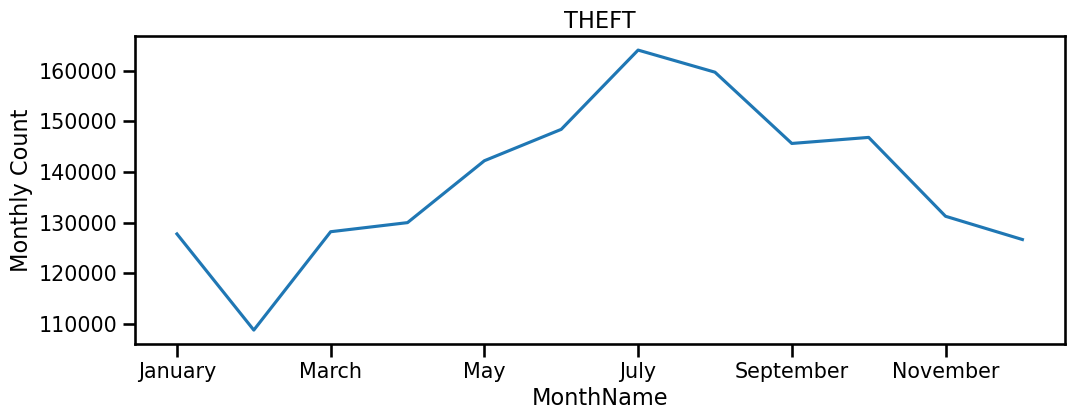

In [66]:
# Single example for the average monthly trend for a single crime 
crimes_df.groupby('MonthName', sort=False)['THEFT'].sum().plot(title='THEFT', ylabel="Monthly Count")

IndexError: index 32 is out of bounds for axis 0 with size 32

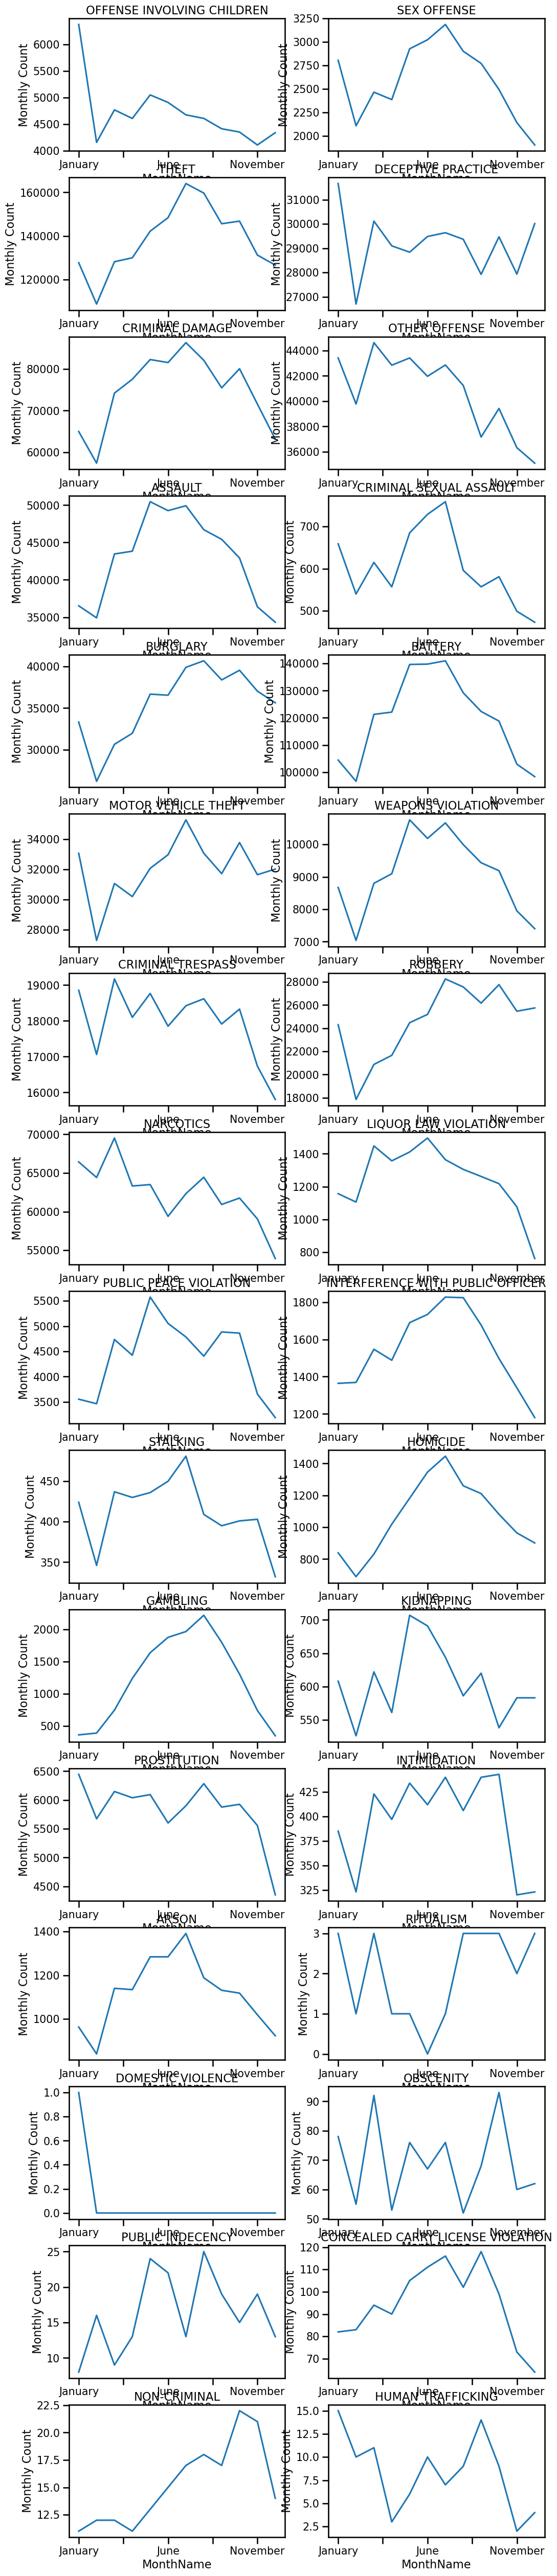

In [67]:
## Plot Monthly Crime Trends for all crimes
# Source: https://stackoverflow.com/questions/64229894/how-to-fix-numpy-ndarray-object-has-no-attribute-get-figure-when-plotting-su

# Instantiate values to size figure
plot_length = len(CRIMES.keys())
max_row = math.ceil(plot_length/2)
max_col = 2

# Set figure dimension and layout of subplots
fig, axes = plt.subplots(max_row, max_col, figsize=(12, plot_length*2))

# Flatten array of axes to have a single group of multiple subplots vs multiple groups
axe = axes.ravel()

# Iterate over columns 
for i, c in enumerate(crimes_df.columns):
   
    crimes_df.groupby('MonthName', sort=False)[c].sum().plot(ax=axe[i], title=c, ylabel="Monthly Count")
  

fig.suptitle('Crime by Month', fontsize=25, y=1)

fig.tight_layout()

Most individual crimes follow the general trend of having the highest rates in summer around July and the lowest rates in winter around February.

A few exceptions are:

> * Offense Involving Children (max: January, min: February)
> * Deceptive Practice (max: January, min: February)
> * Other Offense (max: March, min: December)
> * Criminal Trespass (max: March, min: December)
> * Narcotics (max: March, min: December)
> * Prostitution (max: January, min: December)
> * Obscenity (varies wildly from month-to-month with no clear trend)
> * Human Trafficking (max: January, min: November)

A couple types of crimes have so low numbers that it makes it difficult to really be confident in trends by month. These are: 

> * Ritualism
> * Domestic Violence